# Remove Pectoral Muscle Experimentation

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import pandas            as pd
import numpy             as np
import cv2
import pydicom
import os
import skimage

import modules.imagePreprocessing as iP

## Read MLO scans

In [2]:
# Paths of selected .dcm files
selected_paths = ["../data/Mass/Train/Mass-Training_P_00427_RIGHT_MLO___FULL.dcm",
                  "../data/Mass/Train/Mass-Training_P_00009_RIGHT_MLO___FULL.dcm",
                  "../data/Mass/Train/Mass-Training_P_00914_LEFT_MLO___FULL.dcm",
                  "../data/Mass/Train/Mass-Training_P_01241_RIGHT_MLO___FULL.dcm",
                  "../data/Mass/Train/Mass-Training_P_02092_LEFT_MLO___FULL.dcm"]

ds1 = pydicom.dcmread(selected_paths[0])
ds2 = pydicom.dcmread(selected_paths[1])
ds3 = pydicom.dcmread(selected_paths[2])
ds4 = pydicom.dcmread(selected_paths[3])
ds5 = pydicom.dcmread(selected_paths[4])

ds = [ds1, ds2, ds3, ds4, ds5]

arr1 = ds1.pixel_array
arr2 = ds2.pixel_array
arr3 = ds3.pixel_array
arr4 = ds4.pixel_array
arr5 = ds5.pixel_array

arr = [arr1, arr2, arr3, arr4, arr5]

## Visualise the original MLO images

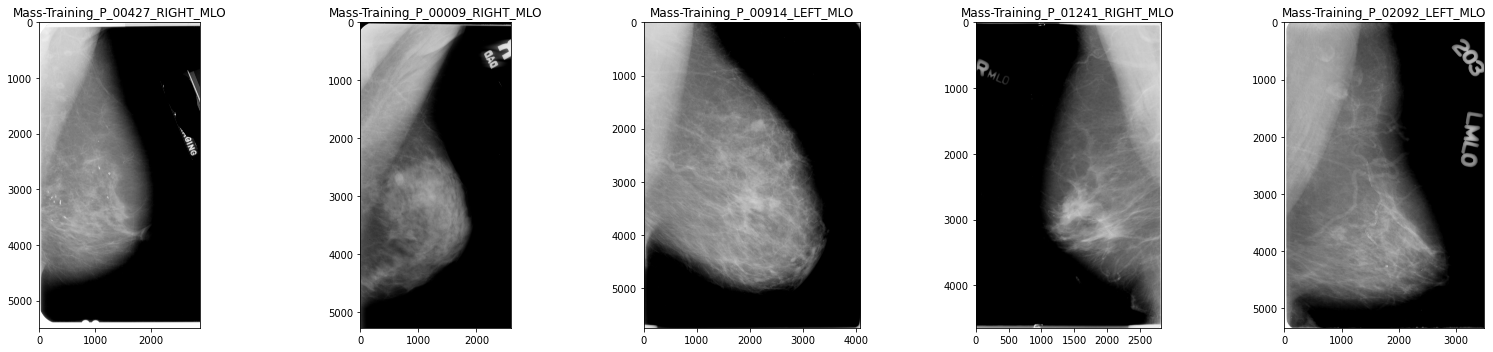

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=len(selected_paths), figsize = (22, 5))

# Plot image
for i in range(len(selected_paths)):
    ax[i].imshow(arr[i], cmap="gray")
    ax[i].set_title(f"{ds[i].PatientID}")
    
plt.tight_layout()
plt.savefig(fname="../outputs/image-preprocessing/remove-pectoral/original.png", dpi=300)

## Perform the image preprocessing pipeline defined in `imagePreprocessing.ipynb`.
- If `image view == MLO`:
    1. Crop
    2. Min-max normalise
    3. Remove artefacts
    4. Horizontal flip
    5. Remove pectoral muscle <--- This is what this notebook figures out.
    6. CLAHE enhancement
    7. Pad
    8. Downsample
    9. Min-max normalise

<br>
    
- **Observations:**
    - Steps 1, 2, 3, 4, 6 and 8 works!

In [4]:
# We append output imges at each step for ease of reference
cropped_img_list = []
norm_img_list = []
binarised_img_list = []
edited_mask_list = []
xlargest_mask_list = []
masked_img_list = []
flipped_img_list = []
clahe_img_list = []
padded_img_list = []

imgPre_list = []

for img in arr:
    
    # Step 1: Initial crop.
    cropped_img = iP.CropBorders(img=img)
    cropped_img_list.append(cropped_img)
    
    # Step 2: Min-max normalise.
    norm_img = iP.MinMaxNormalise(img=cropped_img)
    norm_img_list.append(norm_img)
    
    # Step 3: Remove artefacts.
    binarised_img = iP.OwnGlobalBinarise(img=norm_img, thresh=0.1, maxval=1.0)
    edited_mask = iP.EditMask(mask=binarised_img, ksize=(23, 23), operation="open")
    _, xlargest_mask = iP.XLargestBlobs(mask=edited_mask, top_X=1)
    masked_img = iP.ApplyMask(img=norm_img, mask=xlargest_mask)
    binarised_img_list.append(binarised_img)
    edited_mask_list.append(edited_mask)
    masked_img_list.append(masked_img)
    
    # Step 4: Horizontal flip.
    lr_flip = iP.CheckLRFlip(mask=xlargest_mask)
    if lr_flip:
        masked_img = iP.MakeLRFlip(img=masked_img)
    flipped_img_list.append(masked_img)
    
    # Step 5: Remove pectoral muscle.
    # Not done yet.
    
    # Step 6: CLAHE enhancement.
    clahe_img = iP.clahe(img=masked_img, clip=2.0, tile=(8,8))
    clahe_img_list.append(clahe_img)
    
    # Step 7: Pad.
    padded_img = iP.Pad(img=clahe_img)
    padded_img_list.append(padded_img)
    
    # Step 8: Downsample.
    # Not done yet.
    
    # Step 9: Min-max normalise.
    imgPre = iP.MinMaxNormalise(img=padded_img)
    
    imgPre_list.append(imgPre)

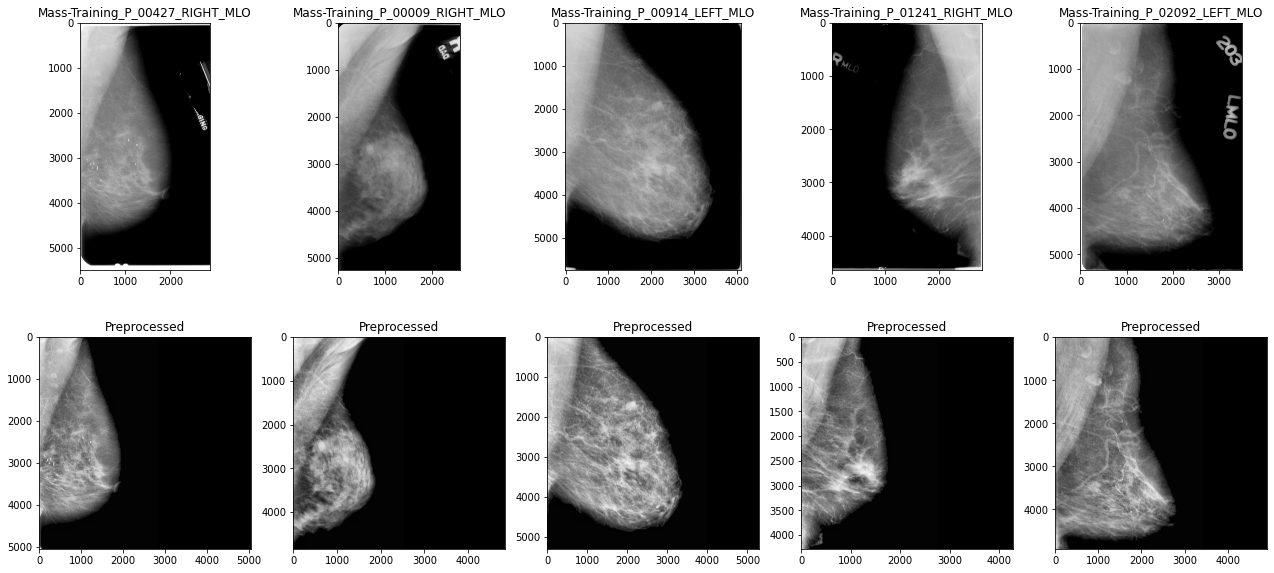

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(22, 10))

for i in range(len(arr)):
    
    # Plot original MLO scans.
    ax[0][i].imshow(arr[i], cmap="gray")
    ax[0][i].set_title(f"{ds[i].PatientID}")
    
    # Plot preprocessed MLO scans.
    ax[1][i].imshow(imgPre_list[i], cmap="gray")
    ax[1][i].set_title("Preprocessed")

---

# Canny Edge Detection